# Modeling of mock data from SLITronomy paper

In this notebook we interested in fitting simulated lens systems from [Galan et al. 2021](https://ui.adsabs.harvard.edu/abs/2021A%26A...647A.176G/abstract). One goal is to compare source reconstructions. In addition we are able to to fit _all_ parameters, i.e. including lens parameters (SIE, external shear), instead of assuming those to be perfectly known like for SLITronomy.

We employ the following _automated_ strategy, each time using knowledge from previous step to refine the model:

1. fit all parameters with smooth profiles only (lens and source), from parameters typically far from the truth;
2. fix lens parameters, and fit the source on a wavelet-regularized pixel grid;
3. fit all at once, both smooth lens parameters and pixelated source.

We can proceed to an additional interesting test: can residuals from step 1 above be abosorbed in perturbations to the lens potential instead?

3. (bis) fix all smooth parameters (lens and smooth), and fit for pixelated potential perturbations in the lens.

__last updated__: 02/08/21

In [1]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Basic imports
import os
import numpy as np
import copy
from astropy.io import fits
from pprint import pprint
from scipy import ndimage
import corner
import pickle as pkl
import optax
import time
from matplotlib.colors import LogNorm
plt.rc('image', interpolation='none')

# Basic JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# jaxtronomy imports
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters
from jaxtronomy.Inference.loss import Loss
from jaxtronomy.Inference.optimization import Optimizer
from jaxtronomy.Inference.sampling import Sampler
from jaxtronomy.Util import image_util, param_util, molet_util

# Universal font size
FS = 18

# Define some custom colormaps
cmap_flux = copy.copy(plt.get_cmap('cubehelix'))
cmap_flux.set_bad(color='black', alpha=1)
cmap_flux_with_neg = copy.copy(plt.get_cmap('cubehelix'))
cmap_flux_with_neg.set_bad(color='#222222', alpha=1)  # emphasize negative pixels when in log scale

### Data grids

In [2]:
#pkl_filename = 'slitronomy-mock_mocksource-highres-single_ssres-3.pkl'
pkl_filename = 'slitronomy-mock_mocksource-highres-group_ssres-3.pkl'
with open(os.path.join('data', pkl_filename), 'rb') as f:
    mock_alldata = pkl.load(f)

class_list, kwargs_true_lens, kwargs_true_source, source_sim_comp, source_sim_data_res = mock_alldata
imsim_class, data_class, psf_class, _, _ = class_list
data = data_class.data

npix, npix_y = data_class.num_pixel_axes
pix_scl = data_class.pixel_width  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
x_coords = xgrid[0, :]
y_coords = ygrid[:, 0]
extent = [x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]]

print(f"image size : ({npix}, {npix_y}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

# supersampling?
kwargs_numerics = {'supersampling_factor': 2, 'convolution_type': 'grid'}

image size : (100, 100) pixels
pixel size : 0.07999999999999999 arcsec
x range    : (-3.9599999999999995, 3.9599999999999995) arcsec
y range    : (-3.9599999999999995, 3.9599999999999995) arcsec


### Load imaging data

-0.1761294535083189


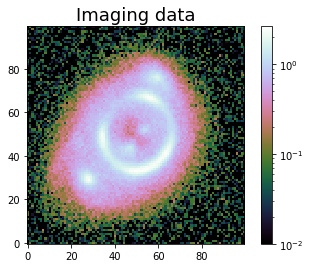

In [3]:
print(data.min())

plt.title("Imaging data", fontsize=FS)
plt.imshow(data, origin='lower', cmap=cmap_flux, norm=LogNorm(1e-2))
plt.colorbar()
plt.show()

### Noise

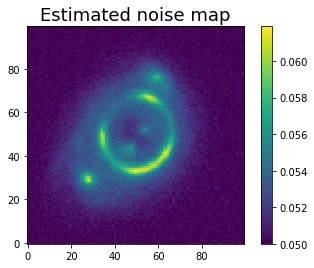

In [4]:
# here we know the true exposure time and background noise level
kwargs_noise = {'background_rms': data_class.background_rms, 
                'exposure_time': data_class.exposure_map}
noise = Noise(npix, npix, **kwargs_noise)
noise.set_data(data)

plt.title("Estimated noise map", fontsize=FS)
plt.imshow(np.sqrt(noise.C_D), origin='lower')
#plt.imshow(np.sqrt(data_class.C_D), origin='lower')
plt.colorbar()
plt.show()

### PSF

In [5]:
kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_class.kernel_point_source}
psf = PSF(**kwargs_psf)

## 1) Analytical lens + analytical smooth source modeling

Here we choose only smooth profile for a first rough model.

### Define modeling choices and initial parameter values

In [6]:
# Source light
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)

# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR_GAMMA_PSI']
lens_mass_model = LensModel(lens_mass_model_list)

kwargs_model = {
    'lens_model_list': lens_mass_model_list,
    'source_model_list': source_light_model_list,
    'lens_light_model_list': [],
}
kwargs_init = {
    'kwargs_lens': [{'theta_E': 1.4, 'e1': 1e-3, 'e2': 1e-3, 'center_x': 1e-3, 'center_y': 1e-3}, {'gamma_ext': 1e-3, 'psi_ext': 1e-3}],
    'kwargs_source': [{'amp': 10., 'R_sersic': 0.8, 'n_sersic': 2., 'e1': 1e-3, 'e2': 1e-3, 'center_x': 1e-3, 'center_y': 1e-3}],
    'kwargs_lens_light': [{}],
}
kwargs_prior = {
    'kwargs_lens': [{}, {}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
kwargs_fixed = {
    'kwargs_lens': [{'center_x': 0., 'center_y': 0.}, {'ra_0': 0., 'dec_0': 0.}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
parameters_allsmooth = Parameters(kwargs_model, kwargs_init, kwargs_prior, kwargs_fixed)

kwargs_true_approx_smooth = {'kwargs_lens': kwargs_true_lens, 'kwargs_source': copy.deepcopy(kwargs_init['kwargs_source']), 'kwargs_lens_light': []}
p_true_approx_smooth = copy.deepcopy(parameters_allsmooth.kwargs2args(kwargs_true_approx_smooth))
param_names = parameters_allsmooth.names
print("truths:", p_true_approx_smooth, param_names, len(p_true_approx_smooth))

print("prior types:", parameters_allsmooth.prior_types)
print("lower/upper bounds (for uniform priors):", *parameters_allsmooth.bounds)

truths: [1.33084116e+00 1.11111111e-01 0.00000000e+00 3.00000000e-02
 7.85398163e-01 1.00000000e+01 8.00000000e-01 2.00000000e+00
 1.00000000e-03 1.00000000e-03 1.00000000e-03 1.00000000e-03] ['theta_E', 'e1', 'e2', 'gamma_ext', 'psi_ext', 'amp', 'R_sersic', 'n_sersic', 'e1', 'e2', 'center_x', 'center_y'] 12
prior types: [None, None, None, None, None, None, None, None, None, None, None, None]
lower/upper bounds (for uniform priors): [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf] [inf inf inf inf inf inf inf inf inf inf inf inf]


### Visualise initial model

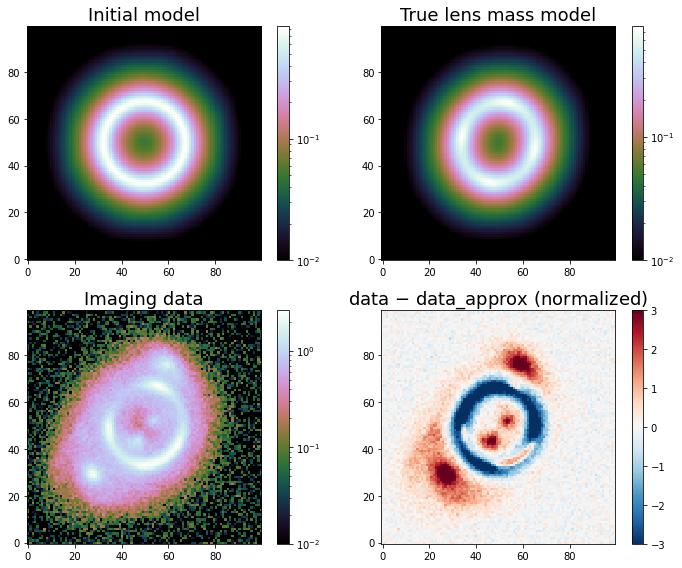

In [7]:
# Generate a lensed image based on source and lens models
lens_image_allsmooth = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         kwargs_numerics=kwargs_numerics)

init_model = lens_image_allsmooth.model(**kwargs_init)
data_approx = lens_image_allsmooth.model(**kwargs_true_approx_smooth)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
ax = axes[0, 0]
ax.set_title("Initial model", fontsize=FS)
img = ax.imshow(init_model, origin='lower', cmap=cmap_flux, norm=LogNorm(1e-2))
fig.colorbar(img, ax=ax)
ax = axes[0, 1]
ax.set_title("True lens mass model", fontsize=FS)
img = ax.imshow(data_approx, origin='lower', cmap=cmap_flux, norm=LogNorm(1e-2))
fig.colorbar(img, ax=ax)
ax = axes[1, 0]
ax.set_title("Imaging data", fontsize=FS)
img = ax.imshow(data, origin='lower', cmap=cmap_flux, norm=LogNorm(1e-2))
fig.colorbar(img, ax=ax)
ax = axes[1, 1]
ax.set_title("data $-$ data_approx (normalized)", fontsize=FS)
img = ax.imshow(data/data.mean()-data_approx/data_approx.mean(), origin='lower', cmap='RdBu_r', vmin=-3, vmax=3)
fig.colorbar(img, ax=ax)
fig.tight_layout()

### Optimize parameters

In [8]:
loss_allsmooth = Loss(data, lens_image_allsmooth, parameters_allsmooth, likelihood_type='chi2')
optimizer_allsmooth = Optimizer(loss_allsmooth, parameters_allsmooth)
print(optimizer_allsmooth.loss(p_true_approx_smooth))

44.184019913163425


In [9]:
# Optimise !
best_fit, logL, extra_fields, runtime \
    = optimizer_allsmooth.minimize(method='BFGS', restart_from_init=True)
print(f"Runtime: {runtime}")
kwargs_final_allsmooth = copy.deepcopy(parameters_allsmooth.ML_values(as_kwargs=True))
pprint(kwargs_final_allsmooth)
#print(extra_fields['result_class'])  # uncomment for full scipy summary

Runtime: 9.727742195129395
{'kwargs_lens': [{'center_x': 0.0,
                  'center_y': 0.0,
                  'e1': array(0.28779717),
                  'e2': array(-0.05409122),
                  'theta_E': array(1.38851323)},
                 {'dec_0': 0.0,
                  'gamma_ext': array(0.06265858),
                  'psi_ext': array(0.09572385),
                  'ra_0': 0.0}],
 'kwargs_lens_light': [],
 'kwargs_source': [{'R_sersic': array(2.69139108),
                    'amp': array(17.80105367),
                    'center_x': array(0.07028303),
                    'center_y': array(0.12710002),
                    'e1': array(-0.14077376),
                    'e2': array(0.30374977),
                    'n_sersic': array(2.07368137)}]}


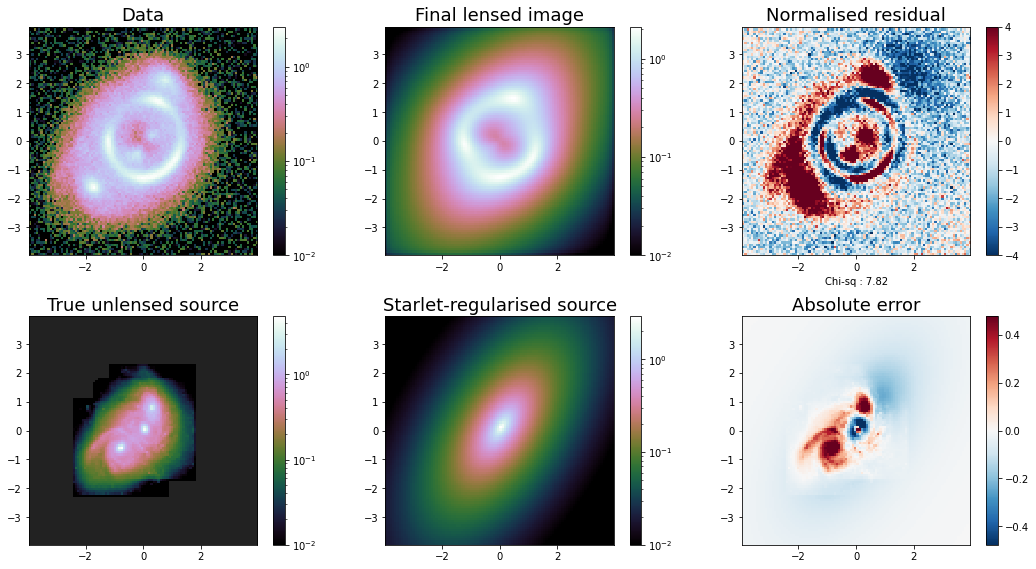

In [10]:
def plot_model_summary(lens_image, kwargs):
    # get true source
    source_true = source_sim_data_res
    
    # get the reconstructed source and model images
    #s_final = parameters_pixsource.kwargs2args(kwargs).reshape(npix, npix)
    kwargs_source_jax = copy.deepcopy(kwargs['kwargs_source'])
    if 'image' in kwargs_source_jax[0]:
        # we need to make sure it's jax.numpy array for source_surface_brightness when using PIXELATED source profile
        kwargs_source_jax[0]['x_coords'] = jnp.asarray(kwargs_source_jax[0]['x_coords'])
        kwargs_source_jax[0]['y_coords'] = jnp.asarray(kwargs_source_jax[0]['y_coords'])
        kwargs_source_jax[0]['image'] = jnp.asarray(kwargs_source_jax[0]['image'])
    s_final = lens_image.source_surface_brightness(kwargs_source_jax, de_lensed=True, unconvolved=True)
    rec_f = lens_image.model(**kwargs)
    noise_var = lens_image.Noise.C_D

    # Image plane reconstruction
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    ax1, ax2, ax3 = axes[0, :]
    img1 = ax1.imshow(data, origin='lower', extent=extent, cmap=cmap_flux, norm=LogNorm(1e-2))
    ax1.set_title("Data", fontsize=FS)
    img2 = ax2.imshow(rec_f, origin='lower', extent=extent, cmap=cmap_flux, norm=LogNorm(1e-2))
    ax2.set_title("Final lensed image", fontsize=FS)
    img3 = ax3.imshow((data - rec_f) / np.sqrt(noise_var), origin='lower', extent=extent, vmin=-4, vmax=4, cmap='RdBu_r')
    ax3.set_title("Normalised residual", fontsize=FS)
    chi2 = jnp.mean((data - rec_f)**2 / noise_var)
    ax3.set_xlabel(f"Chi-sq : {chi2:.2f}")
    for img, ax in zip((img1, img2, img3), axes[0, :]):
        fig.colorbar(img, ax=ax)
    #fig.tight_layout()

    # Source plane reconstruction
    ax1, ax2, ax3 = axes[1, :]
    vmax = source_true.max()
    img1 = ax1.imshow(source_true, origin='lower', extent=extent, cmap=cmap_flux_with_neg, norm=LogNorm(1e-2)) #, vmax=vmax)
    ax1.set_title("True unlensed source", fontsize=FS)
    img2 = ax2.imshow(s_final, origin='lower', extent=extent, cmap=cmap_flux_with_neg, norm=LogNorm(1e-2)) #, vmax=vmax)
    ax2.set_title("Starlet-regularised source", fontsize=FS)
    img3 = ax3.imshow(source_true - s_final, origin='lower', extent=extent, cmap='RdBu_r', vmin=-vmax/10., vmax=vmax/10.)
    ax3.set_title("Absolute error", fontsize=FS)
    for img, ax in zip((img1, img2, img3), axes[1, :]):
        fig.colorbar(img, ax=ax)
    fig.tight_layout()
    
plot_model_summary(lens_image_allsmooth, kwargs_final_allsmooth)

In [11]:
def print_errors(kwargs):
    def _print_error(name, value, estimate):
        spaces = " " * (10 - len(name))
        if value != 0:
            error = 100 * abs(value - estimate) / value
            print(name + ":" + spaces + f"{error:.2f} % ({value} => {estimate})")
        else:
            error = abs(value - estimate)
            print(name + ":" + spaces + f"{error:.2f} [abs] ({value} => {estimate})")
    print("Error")
    print("-----")
    for i, params in enumerate(kwargs_true_lens):
        for key, value in params.items():
            fit = kwargs['kwargs_lens'][i][key]
            _print_error(key, value, fit)
    #for i, params in enumerate(kwargs_source_light):
    #    for key, value in params.items():
    #        fit = kwargs['kwargs_source'][i][key]
    #        _print_error(key, value, fit)
        
print_errors(kwargs_final_allsmooth)

print("\nSource parameters\n-----")
pprint(kwargs_final_allsmooth['kwargs_source'][0])

Error
-----
theta_E:   4.33 % (1.330841155341295 => 1.388513225025276)
center_x:  0.00 [abs] (0 => 0.0)
center_y:  0.00 [abs] (0 => 0.0)
e1:        159.02 % (0.11111111111111108 => 0.2877971671275446)
e2:        0.05 [abs] (0.0 => -0.054091222963287326)
gamma_ext: 108.86 % (0.03 => 0.06265858385312041)
psi_ext:   87.81 % (0.7853981633974483 => 0.0957238543267087)
ra_0:      0.00 [abs] (0 => 0.0)
dec_0:     0.00 [abs] (0 => 0.0)

Source parameters
-----
{'R_sersic': array(2.69139108),
 'amp': array(17.80105367),
 'center_x': array(0.07028303),
 'center_y': array(0.12710002),
 'e1': array(-0.14077376),
 'e2': array(0.30374977),
 'n_sersic': array(2.07368137)}


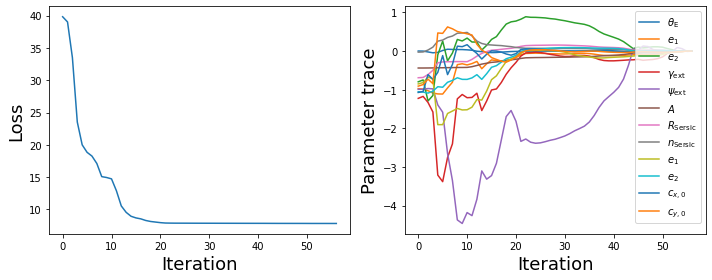

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
ax.plot(range(len(optimizer_allsmooth.loss_history)), optimizer_allsmooth.loss_history)
ax.set_ylabel("Loss", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax = axes[1]
param_history = np.array(optimizer_allsmooth.param_history)
for i in range(len(param_names)):
    ax.plot(range(len(optimizer_allsmooth.loss_history)), (param_history[:, i] - param_history[-1, i]) / param_history[-1, i], label=parameters_allsmooth.symbols[i])
ax.set_ylabel("Parameter trace", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax.legend(loc='upper right')
fig.tight_layout()
plt.show()

## 2) Pixelated source modeling with fixed smooth lens

Here we optimise the source light on a grid of wavelet-regularized pixels, fixing the lens parameters to their previous values

In [13]:
# Source light
source_light_model_list = ['PIXELATED']
source_light_model = LightModel(source_light_model_list)

# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR_GAMMA_PSI']
lens_mass_model = LensModel(lens_mass_model_list)

lens_image_pixsource = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         kwargs_numerics=kwargs_numerics)

kwargs_model = {
    'lens_model_list': lens_mass_model_list,
    'source_model_list': source_light_model_list,
    'lens_light_model_list': [],
}
kwargs_init = {
    'kwargs_lens': [{'theta_E': 1.4, 'e1': 1e-3, 'e2': 1e-3, 'center_x': 1e-3, 'center_y': 1e-3}, {'gamma_ext': 1e-3, 'psi_ext': 1e-3}],
    'kwargs_source': [{'image': 1e-8 * jnp.ones_like(data)}],
    'kwargs_lens_light': [{}],
}
kwargs_prior = {
    'kwargs_lens': [{}, {}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
kwargs_fixed = {
    'kwargs_lens': copy.deepcopy(kwargs_final_allsmooth['kwargs_lens']),
    'kwargs_source': [{'x_coords': x_coords, 'y_coords': y_coords}],
    'kwargs_lens_light': [{}],
}
parameters_pixsource = Parameters(kwargs_model, kwargs_init, kwargs_prior, kwargs_fixed)
kwargs_true = {'kwargs_lens': kwargs_true_lens, 
                 'kwargs_source': [{'image': source_sim_data_res, 'x_coords': x_coords, 'y_coords': y_coords}],
                 'kwargs_lens_light': []}
p_true = copy.deepcopy(parameters_pixsource.kwargs2args(kwargs_true))
param_names = parameters_pixsource.names
print(p_true, param_names[0], param_names[-1], len(p_true))

print("prior types:", parameters_pixsource.prior_types)
print("lower/upper bounds (for uniform priors):", *parameters_pixsource.bounds)

[0. 0. 0. ... 0. 0. 0.] s_0 s_9999 10000
prior types: [None]
lower/upper bounds (for uniform priors): [-inf] [inf]


In [14]:
loss_pixsource = Loss(data, lens_image_pixsource, parameters_pixsource, 
                      likelihood_type='l2_norm',
                      regularization_terms=['l1_starlet_source', 
                                            'l1_battle_source',
                                            'positivity_source'], 
                      regularization_strengths=[3, 3, 3])
#optimizer_pixsource = Optimizer(loss_pixsource, parameters_pixsource)
print(loss_pixsource(p_true))

5.310552203813205


In [15]:
# Max number of iterations
n_iter = 1000

# Global learning rate (or initial value when decaying)
learning_rate = 1e-2

# Exponential decay of the learning rate
scheduler = optax.exponential_decay(
    init_value=learning_rate, 
    transition_steps=n_iter,
    decay_rate=0.99)

# Combining gradient transforms using `optax.chain`
optimizer_optax = optax.chain(
    #optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm
    optax.scale_by_belief(),  # Use the updates from an optimizer
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler
    optax.scale(-1.)  # because gradient *descent*
)

params = jnp.array(parameters_pixsource.initial_values())
opt_state = optimizer_optax.init(params)
grad_loss_optax = jax.jit(jax.grad(loss_pixsource))

start_time = time.time()

# A simple update loop.
for _ in range(n_iter):
    updates, opt_state = optimizer_optax.update(grad_loss_optax(params), opt_state, params)
    params = optax.apply_updates(params, updates)

print(f"Runtime: {time.time() - start_time : 0.2f} s")

p_final_pixsource = params
print("Final loss : {:.2f}".format(loss_pixsource(p_final_pixsource)))

Runtime:  41.65 s
Final loss : 2.49


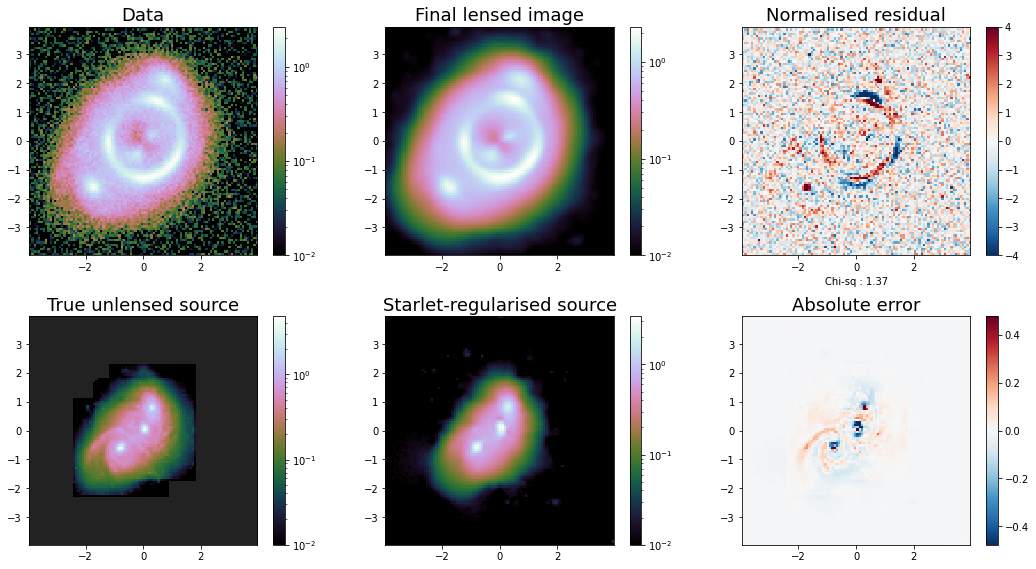

In [16]:
kwargs_final_pixsource = copy.deepcopy(parameters_pixsource.args2kwargs(p_final_pixsource))
plot_model_summary(lens_image_pixsource, kwargs_final_pixsource)

In [17]:
print_errors(kwargs_final_pixsource)

Error
-----
theta_E:   4.33 % (1.330841155341295 => 1.388513225025276)
center_x:  0.00 [abs] (0 => 0.0)
center_y:  0.00 [abs] (0 => 0.0)
e1:        159.02 % (0.11111111111111108 => 0.2877971671275446)
e2:        0.05 [abs] (0.0 => -0.054091222963287326)
gamma_ext: 108.86 % (0.03 => 0.06265858385312041)
psi_ext:   87.81 % (0.7853981633974483 => 0.0957238543267087)
ra_0:      0.00 [abs] (0 => 0.0)
dec_0:     0.00 [abs] (0 => 0.0)


## 3) Optimize pixelated source and smooth lens

In [18]:
lens_image_final = copy.deepcopy(lens_image_pixsource)

kwargs_model = {
    'lens_model_list': lens_mass_model_list,
    'source_model_list': source_light_model_list,
    'lens_light_model_list': [],
}
kwargs_init = {
    'kwargs_lens': copy.deepcopy(kwargs_final_allsmooth['kwargs_lens']),
    'kwargs_source': [{'image': copy.deepcopy(kwargs_final_pixsource['kwargs_source'][0]['image'])}],
    'kwargs_lens_light': [{}],
}
kwargs_prior = {
    'kwargs_lens': [{}, {}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
kwargs_fixed = {
    'kwargs_lens': [{}, {'ra_0': 0., 'dec_0': 0.}],
    'kwargs_source': [{'x_coords': x_coords, 'y_coords': y_coords}],
    'kwargs_lens_light': [{}],
}
parameters_final = Parameters(kwargs_model, kwargs_init, kwargs_prior, kwargs_fixed)
kwargs_true = {'kwargs_lens': kwargs_true_lens, 
                 'kwargs_source': [{'image': source_sim_data_res, 'x_coords': x_coords, 'y_coords': y_coords}],
                 'kwargs_lens_light': []}
p_true = copy.deepcopy(parameters_final.kwargs2args(kwargs_true))
param_names = parameters_final.names
print(p_true, param_names[0], param_names[-1], len(p_true))

print("prior types:", parameters_final.prior_types)
print("lower/upper bounds (for uniform priors):", *parameters_final.bounds)

[1.33084116 0.11111111 0.         ... 0.         0.         0.        ] theta_E s_9999 10007
prior types: [None, None, None, None, None, None, None, None]
lower/upper bounds (for uniform priors): [-inf -inf -inf -inf -inf -inf -inf -inf] [inf inf inf inf inf inf inf inf]


In [19]:
len(parameters_final.kwargs2args(kwargs_init))

10007

In [20]:
loss_final = Loss(data, lens_image_final, parameters_final, 
                      likelihood_type='l2_norm',
                      regularization_terms=['l1_starlet_source', 
                                            'l1_battle_source',
                                            'positivity_source'], 
                      regularization_strengths=[3, 3, 3])
#optimizer_final = Optimizer(loss_final, parameters_final)
print(loss_final(p_true))

2.637508535505489


In [21]:
# Max number of iterations
n_iter = 1000

# Global learning rate (or initial value when decaying)
learning_rate = 1e-2

# Exponential decay of the learning rate
scheduler = optax.exponential_decay(
    init_value=learning_rate, 
    transition_steps=n_iter,
    decay_rate=0.99)

# Combining gradient transforms using `optax.chain`
optimizer_optax = optax.chain(
    #optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm
    optax.scale_by_belief(),  # Use the updates from an optimizer
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler
    optax.scale(-1.)  # because gradient *descent*
)

params = jnp.array(parameters_final.initial_values())
opt_state = optimizer_optax.init(params)
grad_loss_optax = jax.jit(jax.grad(loss_final))

start_time = time.time()

# A simple update loop.
for _ in range(n_iter):
    updates, opt_state = optimizer_optax.update(grad_loss_optax(params), opt_state, params)
    params = optax.apply_updates(params, updates)

print(f"Runtime: {time.time() - start_time : 0.2f} s")

p_final_final = params
print("Final loss : {:.2f}".format(loss_final(p_final_final)))

Runtime:  43.51 s
Final loss : 2.11


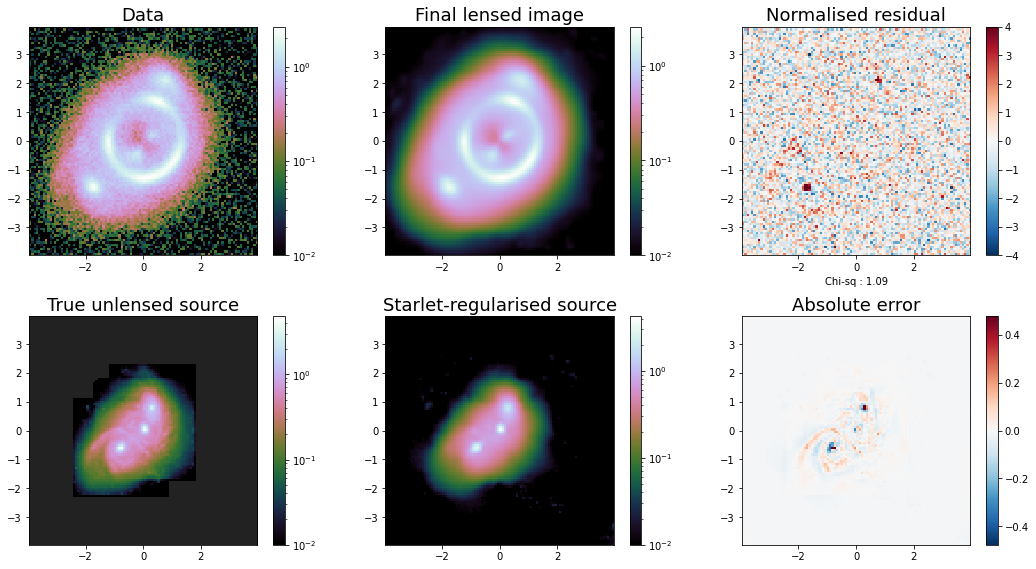

In [22]:
kwargs_final_final = copy.deepcopy(parameters_final.args2kwargs(p_final_final))
plot_model_summary(lens_image_final, kwargs_final_final)

In [23]:
print_errors(kwargs_final_final)

Error
-----
theta_E:   0.15 % (1.330841155341295 => 1.3288432804100805)
center_x:  0.01 [abs] (0 => -0.011372046950414319)
center_y:  0.01 [abs] (0 => -0.005434782376871548)
e1:        7.27 % (0.11111111111111108 => 0.10303537126282768)
e2:        0.00 [abs] (0.0 => -0.004905936802301894)
gamma_ext: 5.66 % (0.03 => 0.028301581410757202)
psi_ext:   13.22 % (0.7853981633974483 => 0.8892103533999104)
ra_0:      0.00 [abs] (0 => 0.0)
dec_0:     0.00 [abs] (0 => 0.0)


## 2) _bis_ Can residuals from step 1 be absorbed with potential perturbations?

In [24]:
# Source light
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)

# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR_GAMMA_PSI', 'PIXELATED']
lens_mass_model = LensModel(lens_mass_model_list)

lens_image_pixpot = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         kwargs_numerics=kwargs_numerics)

# Lower resolution interpolation grid for pixelated potential
npix_lowres = npix // 4
x_coords_lowres = np.linspace(extent[0], extent[1], npix_lowres)
y_coords_lowres = np.linspace(extent[2], extent[3], npix_lowres)
x_grid_lowres, y_grid_lowres = np.meshgrid(x_coords_lowres, y_coords_lowres)

kwargs_model = {
    'lens_model_list': lens_mass_model_list,
    'source_model_list': source_light_model_list,
    'lens_light_model_list': [],
}
kwargs_init = {
    'kwargs_lens': [{}, {}] + [{'psi_grid': 1e-8 * jnp.ones((npix_lowres, npix_lowres))}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
kwargs_prior = {
    'kwargs_lens': [{}, {}, {}],
    'kwargs_source': [{}],
    'kwargs_lens_light': [{}],
}
kwargs_fixed = {
    # here we fix all smooth model parameters to step 2 results
    'kwargs_lens': copy.deepcopy(kwargs_final_allsmooth['kwargs_lens']) + [{'x_coords': x_coords_lowres, 'y_coords': y_coords_lowres}],
    'kwargs_source': copy.deepcopy(kwargs_final_allsmooth['kwargs_source']),
    'kwargs_lens_light': [{}],
}
parameters_pixpot = Parameters(kwargs_model, kwargs_init, kwargs_prior, kwargs_fixed)
kwargs_true_hybrid = {'kwargs_lens': kwargs_true_lens + [{'x_coords': x_coords_lowres, 'y_coords': y_coords_lowres, 'psi_grid': np.zeros((npix_lowres, npix_lowres))}], 
                 'kwargs_source': [{'image': source_sim_data_res, 'x_coords': x_coords, 'y_coords': y_coords}],
                 'kwargs_lens_light': []}
p_true_hybrid = copy.deepcopy(parameters_pixpot.kwargs2args(kwargs_true_hybrid))
param_names = parameters_pixpot.names
print(p_true_hybrid[0], param_names[0], param_names[-1], len(p_true_hybrid))

print("prior types:", parameters_pixpot.prior_types)
print("lower/upper bounds (for uniform priors):", *parameters_pixpot.bounds)

0.0 dpsi_0 dpsi_624 625
prior types: [None]
lower/upper bounds (for uniform priors): [-inf] [inf]


In [25]:
# load pre-compute potential noise map
dpsi_noise_map = np.load(f'data/dpsi_1sigma_slitronomy_mock_single_{npix_lowres}px_fullmass_fullamp.npy')

loss_pixpot = Loss(data, lens_image_pixpot, parameters_pixpot, 
                      likelihood_type='l2_norm',
                      regularization_terms=['l1_starlet_potential', 
                                            'l1_battle_potential'], 
                      regularization_strengths=[3, 3],
                      potential_noise_map=dpsi_noise_map)
optimizer_pixpot = Optimizer(loss_pixpot, parameters_pixpot)
print(optimizer_pixpot.loss(p_true_hybrid))

8.801127916941299


In [26]:
# Max number of iterations
n_iter = 1000

# Global learning rate (or initial value when decaying)
learning_rate = 1e-2

# Exponential decay of the learning rate
scheduler = optax.exponential_decay(
    init_value=learning_rate, 
    transition_steps=n_iter,
    decay_rate=0.99)

# Combining gradient transforms using `optax.chain`
optimizer_optax = optax.chain(
    #optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm
    optax.scale_by_belief(),  # Use the updates from an optimizer
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler
    optax.scale(-1.)  # because gradient *descent*
)

params = jnp.array(parameters_pixpot.initial_values())
opt_state = optimizer_optax.init(params)
grad_loss_optax = jax.jit(jax.grad(loss_pixpot))

start_time = time.time()

# A simple update loop.
for _ in range(n_iter):
    updates, opt_state = optimizer_optax.update(grad_loss_optax(params), opt_state, params)
    params = optax.apply_updates(params, updates)

print(f"Runtime: {time.time() - start_time : 0.2f} s")

p_final_pixpot = params
print("Final loss : {:.2f}".format(loss_pixpot(p_final_pixpot)))

kwargs_final_pixpot = copy.deepcopy(parameters_pixpot.args2kwargs(p_final_pixpot))

Runtime:  42.12 s
Final loss : 2.30


delta_psi shift & normalization by mean: 0.009176074438693881 0.0


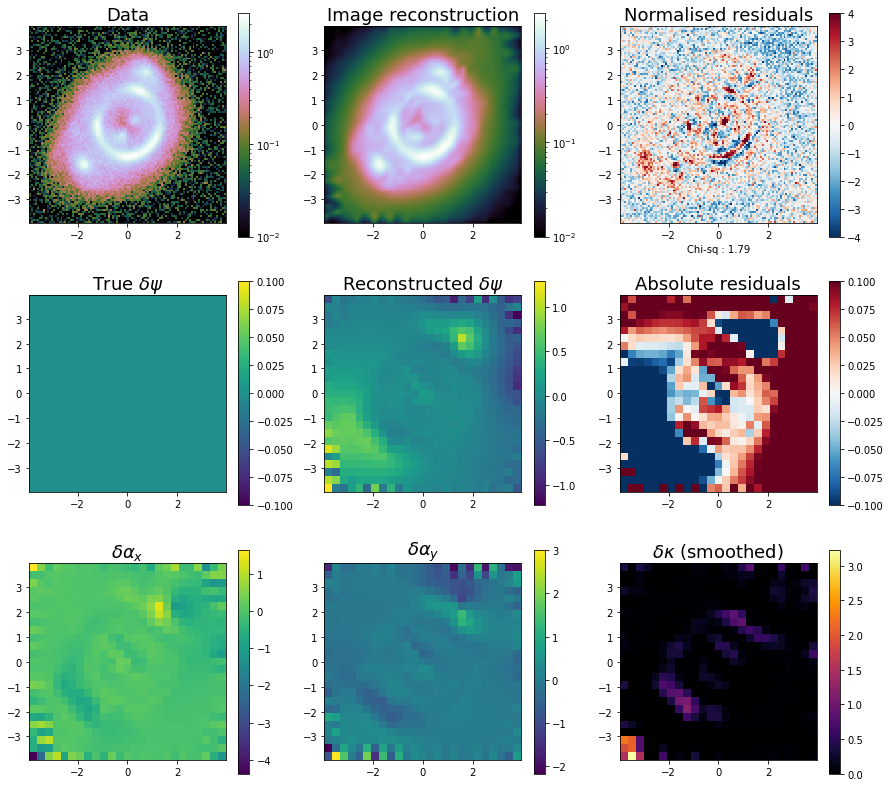

In [27]:
def plot_pixelated_potential_result(lens_image, kwargs_f, shift_potential='min', with_mask=True):
    # Generate a mask on low-res grid
    rmin = 0.4
    rmax = 3.
    radius_lowres = np.hypot(x_grid_lowres, y_grid_lowres)
    mask_lowres = ((radius_lowres >= rmin) & (radius_lowres <= rmax)).astype(float)
    
    # create the resulting model image
    rec_image = lens_image.model(**kwargs_f)
    noise_var = lens_image.Noise.C_D
    alpha_x, alpha_y = lens_image.LensModel.alpha(x_grid_lowres, y_grid_lowres, kwargs_f['kwargs_lens'], k=-1)
    kappa = lens_image.LensModel.kappa(x_grid_lowres, y_grid_lowres, kwargs_f['kwargs_lens'], k=-1)

    # here we know that there are no perturbations in the true potential
    psi_grid_true_lowres = np.zeros((npix_lowres, npix_lowres))
    
    # Reshape the final psi grid
    psi_grid_rec = kwargs_f['kwargs_lens'][-1]['psi_grid']
    if shift_potential == 'min':
        min_in_mask = (psi_grid_rec * mask_lowres).min()
        psi_grid_rec = psi_grid_rec - min_in_mask
        print("delta_psi shift by min:", min_in_mask)
    elif shift_potential == 'mean':
        mean_in_mask = (psi_grid_rec * mask_lowres).mean()
        true_mean_in_mask = (psi_grid_true_lowres * mask_lowres).mean()
        psi_grid_rec = psi_grid_rec - mean_in_mask + true_mean_in_mask
        print("delta_psi shift & normalization by mean:", mean_in_mask, true_mean_in_mask)
        
    fig, axes = plt.subplots(3, 3, figsize=(15, 14))
    ax = axes[0, 0]
    img = ax.imshow(data, origin='lower', extent=extent, cmap=cmap_flux, norm=LogNorm(1e-2))
    ax.set_title("Data", fontsize=FS)
    fig.colorbar(img, ax=ax)
    ax = axes[0, 1]
    img = ax.imshow(rec_image, origin='lower', extent=extent, cmap=cmap_flux, norm=LogNorm(1e-2))
    ax.set_title("Image reconstruction", fontsize=FS)
    fig.colorbar(img, ax=ax)
    ax = axes[0, 2]
    img = ax.imshow((data - rec_image) / jnp.sqrt(noise_var), origin='lower', cmap='RdBu_r', vmin=-4, vmax=4, extent=extent)
    ax.set_title("Normalised residuals", fontsize=FS)
    ax.set_xlabel(f"Chi-sq : {np.mean((data - rec_image)**2 / noise_var):.2f}")
    fig.colorbar(img, ax=ax)

    ax = axes[1, 0]
    psi_grid_true_show = psi_grid_true_lowres
    if with_mask:
        psi_grid_true_show *= mask_lowres
    img = ax.imshow(psi_grid_true_show, origin='lower', extent=extent)
    ax.set_title("True $\delta\psi$", fontsize=FS)
    fig.colorbar(img, ax=ax)
    ax = axes[1, 1]
    psi_grid_rec_show = psi_grid_rec
    if with_mask:
        psi_grid_rec_show *= mask_lowres
    img = ax.imshow(psi_grid_rec_show, origin='lower', extent=extent)
    ax.set_title("Reconstructed $\delta\psi$", fontsize=FS)
    fig.colorbar(img, ax=ax)
    ax = axes[1, 2]
    abs_res_show = (psi_grid_true_lowres - psi_grid_rec)
    if with_mask:
        abs_res_show *= mask_lowres
    vmax = 0.5 * np.max(np.abs(psi_grid_true_lowres))
    img = ax.imshow(abs_res_show, origin='lower', cmap='RdBu_r', vmin=-vmax, vmax=vmax, extent=extent)
    ax.set_title("Absolute residuals", fontsize=FS)
    fig.colorbar(img, ax=ax)

    ax = axes[2, 0]
    alpha_x_rec_show = alpha_x
    if with_mask:
        alpha_x_rec_show *= mask_lowres
    ax.set_title(r"$\delta\alpha_x$", fontsize=FS)
    im = ax.imshow(alpha_x_rec_show, origin='lower', alpha=1, extent=extent)
    fig.colorbar(im, ax=ax)
    ax = axes[2, 1]
    alpha_y_rec_show = alpha_y
    if with_mask:
        alpha_y_rec_show *= mask_lowres
    ax.set_title(r"$\delta\alpha_y$", fontsize=FS)
    im = ax.imshow(alpha_y_rec_show, origin='lower', alpha=1, extent=extent)
    fig.colorbar(im, ax=ax)
    ax = axes[2, 2]
    #kappa_rec_show = kappa
    kappa_rec_show = ndimage.gaussian_filter(kappa, 1)
    if with_mask:
        kappa_rec_show *= mask_lowres
    ax.set_title(r"$\delta\kappa$ (smoothed)", fontsize=FS)
    im = ax.imshow(kappa_rec_show, origin='lower', cmap='inferno', alpha=1, extent=extent, vmin=0)
    fig.colorbar(im, ax=ax)
    
    plt.show()
    
plot_pixelated_potential_result(lens_image_pixpot, kwargs_final_pixpot,
                                shift_potential='mean', with_mask=False)

Model residuals worsen, and the best-fit potential perturbations are non-physical. In addition, using another optimizer (e.g. `optax`) instead if `scipy.minimize` leads to a completely different solution.

$\Longrightarrow$ Residuals from step 1 cannot be absorbed into potential perturbations!